In [16]:
import requests
import pandas as pd
import numpy as np

url = "https://api.coingecko.com/api/v3/coins/markets"

params = {
    "vs_currency": "usd",
    "order": "market_cap_desc",
    "per_page": 50,   # pull more so filtering still leaves ~20
    "page": 1,
    "sparkline": False
}

response = requests.get(url, params=params)
data = response.json()

df = pd.DataFrame(data)[
    ["market_cap_rank", "symbol", "name", "market_cap", "current_price"]
]

# -----------------------------
# Filters
# -----------------------------

stablecoins = {
    "usdt", "usdc", "busd", "dai", "tusd",
    "usdp", "fdusd", "gusd", "lusd",
    "ust", "ustc", "usdd", "eurc",'usds','usde','bsc-usd','usd1','pyusd'
    
}

# normalize text
df["symbol"] = df["symbol"].str.lower()
df["name"] = df["name"].str.lower()

# remove stablecoins
df = df[~df["symbol"].isin(stablecoins)]

# remove wrapped coins
df = df[
    ~df["name"].str.contains("wrapped") &
    ~df["symbol"].str.startswith("w")
]

# take top 20 after filtering
df = df.sort_values("market_cap", ascending=False).head(20)

print(df)


    market_cap_rank      symbol          name     market_cap  current_price
0                 1         btc       bitcoin  1364337020346   68252.000000
1                 2         eth      ethereum   241274530667    1997.010000
3                 4         xrp           xrp    85281901284       1.400000
4                 5         bnb           bnb    83087545559     608.690000
6                 7         sol        solana    46907865791      82.700000
7                 8         trx          tron    26120782652       0.275789
8                 9  figr_heloc  figure heloc    15546080295       1.032000
9                10        doge      dogecoin    15483126060       0.091795
11               12         bch  bitcoin cash    10417863307     521.060000
12               13         ada       cardano     9641037240       0.262501
14               15         leo     leo token     7738138502       8.400000
15               16        hype   hyperliquid     6946695141      29.160000
17          

In [17]:
binance_symbols = requests.get(
    "https://api.binance.com/api/v3/exchangeInfo"
).json()

binance_assets = {
    s["baseAsset"].lower()
    for s in binance_symbols["symbols"]
    if s["quoteAsset"] == "USDT"
}

df = df[df["symbol"].isin(binance_assets)]

In [18]:
df

,market_cap_rank,symbol,name,market_cap,current_price
0,1,btc,bitcoin,1364337020346,68252.000000
1,2,eth,ethereum,241274530667,1997.010000
3,4,xrp,xrp,85281901284,1.400000
4,5,bnb,bnb,83087545559,608.690000
6,7,sol,solana,46907865791,82.700000
7,8,trx,tron,26120782652,0.275789
9,10,doge,dogecoin,15483126060,0.091795
11,12,bch,bitcoin cash,10417863307,521.060000
12,13,ada,cardano,9641037240,0.262501
17,18,xmr,monero,6320182424,342.480000


In [19]:
from binance.client import Client
import datetime
client = Client()


end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=60)

klines_btc = client.get_historical_klines(
    "BTCUSDT",                     # symbol
    Client.KLINE_INTERVAL_15MINUTE,    # interval:15 minutes
    start_date.strftime("%d %b %Y %H:%M:%S"),
    end_date.strftime("%d %b %Y %H:%M:%S")
)
df_btc = pd.DataFrame(klines_btc, columns=[
    "timestamp", "open", "high", "low", "close", "volume",
    "close_time", "quote_asset_volume", "number_of_trades",
    "taker_buy_base", "taker_buy_quote", "ignore"
])
df_btc=df_btc[['timestamp','close']]

klines_eth = client.get_historical_klines(
    "ETHUSDT",                     # symbol
    Client.KLINE_INTERVAL_15MINUTE,    # interval:15 minutes
    start_date.strftime("%d %b %Y %H:%M:%S"),
    end_date.strftime("%d %b %Y %H:%M:%S")
)
klines_bnb = client.get_historical_klines(
    "BNBUSDT",                     # symbol
    Client.KLINE_INTERVAL_15MINUTE,    # interval:15 minutes
    start_date.strftime("%d %b %Y %H:%M:%S"),
    end_date.strftime("%d %b %Y %H:%M:%S")
)

C:\Users\Acer\AppData\Local\Temp\ipykernel_15080\358202985.py:9: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines_btc = client.get_historical_klines(
C:\Users\Acer\AppData\Local\Temp\ipykernel_15080\358202985.py:22: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines_eth = client.get_historical_klines(
C:\Users\Acer\AppData\Local\Temp\ipykernel_1508

In [20]:
import pandas as pd
from binance.client import Client

def get_close_prices_15m(
    client,
    symbols,
    start_date,
    end_date
):
    """
    Download 15-minute close prices for selected coins.

    Parameters
    ----------
    client : Binance Client
    symbols : list[str]
        Example: ["BTC", "ETH", "BNB", "SOL"]
    start_date : datetime
    end_date : datetime

    Returns
    -------
    pd.DataFrame
        timestamp × coin close prices
    """

    close_dfs = []

    for sym in symbols:
        pair = sym.upper() + "USDT"
        print(f"Downloading {pair}")

        klines = client.get_historical_klines(
            pair,
            Client.KLINE_INTERVAL_15MINUTE,
            start_date.strftime("%d %b %Y %H:%M:%S"),
            end_date.strftime("%d %b %Y %H:%M:%S")
        )

        df = pd.DataFrame(klines, columns=[
            "timestamp", "open", "high", "low", "close", "volume",
            "close_time", "quote_asset_volume", "number_of_trades",
            "taker_buy_base", "taker_buy_quote", "ignore"
        ])

        df = df[["timestamp", "close"]]
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
        df["close"] = df["close"].astype(float)

        df = df.rename(columns={"close": sym.upper()})

        close_dfs.append(df)

    # ---- merge all coins on timestamp ----
    df_close = close_dfs[0]

    for d in close_dfs[1:]:
        df_close = df_close.merge(
            d,
            on="timestamp",
            how="outer"
        )

    df_close = (
        df_close
        .sort_values("timestamp")
        .set_index("timestamp")
    )

    return df_close


In [21]:

import datetime



#start_date = datetime(2025, 1, 1)
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=30)


df_close_15m = get_close_prices_15m(
    client,
    df['symbol'].tolist(),
    start_date,
    end_date
)


C:\Users\Acer\AppData\Local\Temp\ipykernel_15080\3597688465.py:33: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines = client.get_historical_klines(


C:\Users\Acer\AppData\Local\Temp\ipykernel_15080\3597688465.py:33: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines = client.get_historical_klines(


C:\Users\Acer\AppData\Local\Temp\ipykernel_15080\3597688465.py:33: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines = client.get_historical_klines(


C:\Users\Acer\AppData\Local\Temp\ipykernel_15080\3597688465.py:33: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines = client.get_historical_klines(


C:\Users\Acer\AppData\Local\Temp\ipykernel_15080\3597688465.py:33: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines = client.get_historical_klines(


C:\Users\Acer\AppData\Local\Temp\ipykernel_15080\3597688465.py:33: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines = client.get_historical_klines(


C:\Users\Acer\AppData\Local\Temp\ipykernel_15080\3597688465.py:33: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines = client.get_historical_klines(


C:\Users\Acer\AppData\Local\Temp\ipykernel_15080\3597688465.py:33: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines = client.get_historical_klines(


C:\Users\Acer\AppData\Local\Temp\ipykernel_15080\3597688465.py:33: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines = client.get_historical_klines(


C:\Users\Acer\AppData\Local\Temp\ipykernel_15080\3597688465.py:33: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines = client.get_historical_klines(
C:\Users\Acer\AppData\Local\Temp\ipykernel_15080\3597688465.py:33: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines = client.get_historical_klines(


C:\Users\Acer\AppData\Local\Temp\ipykernel_15080\3597688465.py:33: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines = client.get_historical_klines(


C:\Users\Acer\AppData\Local\Temp\ipykernel_15080\3597688465.py:33: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines = client.get_historical_klines(


C:\Users\Acer\AppData\Local\Temp\ipykernel_15080\3597688465.py:33: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines = client.get_historical_klines(


C:\Users\Acer\AppData\Local\Temp\ipykernel_15080\3597688465.py:33: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines = client.get_historical_klines(


C:\Users\Acer\AppData\Local\Temp\ipykernel_15080\3597688465.py:33: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  klines = client.get_historical_klines(


Text(0, 0.5, 'Price')

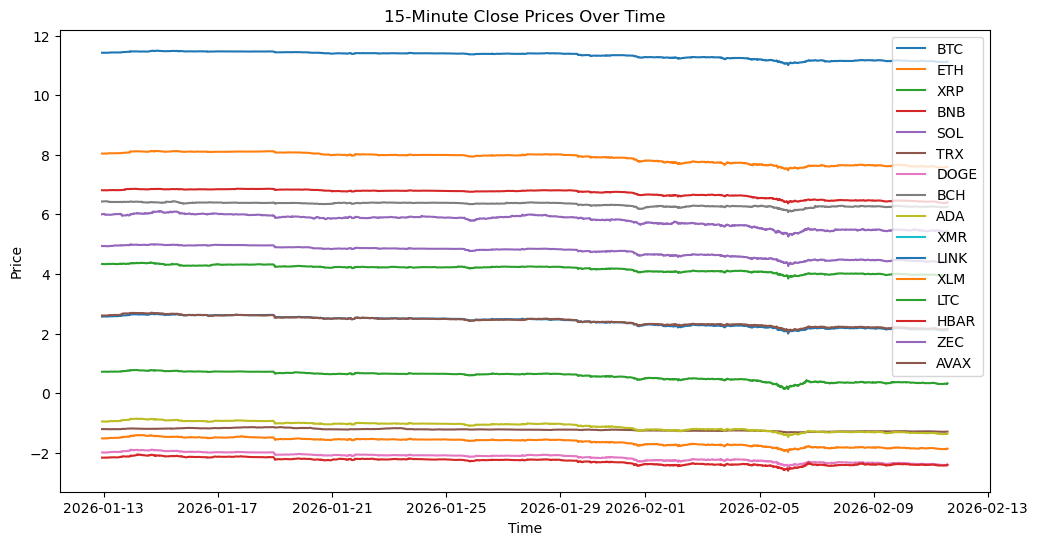

In [22]:
import matplotlib.pyplot as plt

normalized_df = np.log(df_close_15m) # / df_close_15m.iloc[0]  # Normalize to the first row

plt.figure(figsize=(12, 6))
for col in normalized_df.columns:
    plt.plot(normalized_df.index, normalized_df[col], label=col)
plt.legend()
plt.title("15-Minute Close Prices Over Time")
plt.xlabel("Time")
plt.ylabel("Price")

In [23]:
normalized_df.head()

,BTC,ETH,XRP,BNB,SOL,TRX,DOGE,BCH,ADA,XMR,LINK,XLM,LTC,HBAR,ZEC,AVAX
timestamp,,,,,,,,,,,,,,,,
2026-01-12 22:30:00,11.422343,8.040067,0.720519,6.809337,4.938065,-1.205307,-1.987555,6.430364,-0.949331,NaN,2.571849,-1.515037,4.334935,-2.162128,6.002578,2.607861
2026-01-12 22:45:00,11.421303,8.037679,0.720033,6.808819,4.935696,-1.203973,-1.988139,6.429719,-0.948556,NaN,2.569554,-1.516859,4.330865,-2.162997,6.002602,2.605648
2026-01-12 23:00:00,11.420372,8.036470,0.717254,6.808012,4.933538,-1.205307,-1.991431,6.430042,-0.950623,NaN,2.569554,-1.518684,4.330207,-2.164912,6.002998,2.603430
2026-01-12 23:15:00,11.421570,8.038396,0.720373,6.809569,4.936917,-1.204640,-1.988358,6.435028,-0.945462,NaN,2.571084,-1.514128,4.332968,-2.161086,6.009083,2.604909
2026-01-12 23:30:00,11.421629,8.037879,0.719838,6.809999,4.937061,-1.204640,-1.989016,6.434707,-0.950365,NaN,2.571084,-1.516859,4.331260,-2.162649,6.009182,2.604170


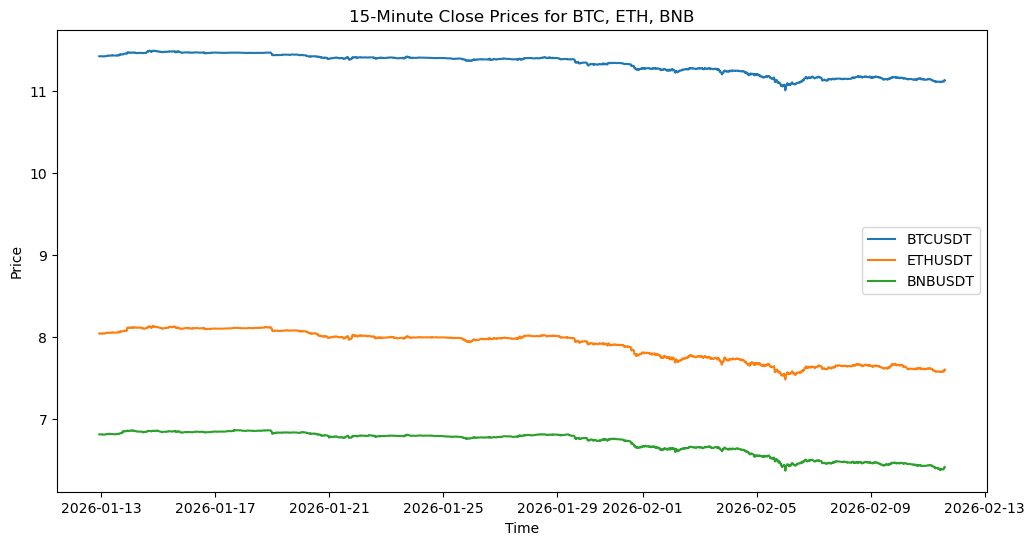

In [24]:
plt.figure(figsize=(12,6))
plt.plot(normalized_df.index, normalized_df['BTC'], label='BTCUSDT')
plt.plot(normalized_df.index, normalized_df['ETH'], label='ETHUSDT')
plt.plot(normalized_df.index, normalized_df['BNB'], label='BNBUSDT')
plt.legend()
plt.title("15-Minute Close Prices for BTC, ETH, BNB")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

In [25]:
normalized_df.head()
# Drop columns where ALL values are NaN
df_close_15m = df_close_15m.dropna(axis=1, how='all')
normalized_df=normalized_df.dropna(axis=1, how='all')

# Or drop columns with ANY NaN values
#df_close_15m = df_close_15m.dropna(axis=1, how='any')

In [26]:
df_close_15m

,BTC,ETH,XRP,BNB,SOL,TRX,DOGE,BCH,ADA,LINK,XLM,LTC,HBAR,ZEC,AVAX
timestamp,,,,,,,,,,,,,,,
2026-01-12 22:30:00,91339.90,3102.82,2.0555,906.27,139.50,0.2996,0.13703,620.4,0.3870,13.09,0.2198,76.32,0.11508,404.47,13.57
2026-01-12 22:45:00,91244.99,3095.42,2.0545,905.80,139.17,0.3000,0.13695,620.0,0.3873,13.06,0.2194,76.01,0.11498,404.48,13.54
2026-01-12 23:00:00,91160.07,3091.68,2.0488,905.07,138.87,0.2996,0.13650,620.2,0.3865,13.06,0.2190,75.96,0.11476,404.64,13.51
2026-01-12 23:15:00,91269.34,3097.64,2.0552,906.48,139.34,0.2998,0.13692,623.3,0.3885,13.08,0.2200,76.17,0.11520,407.11,13.53
2026-01-12 23:30:00,91274.69,3096.04,2.0541,906.87,139.36,0.2998,0.13683,623.1,0.3866,13.08,0.2194,76.04,0.11502,407.15,13.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-11 13:15:00,67018.77,1948.72,1.3639,592.62,80.91,0.2743,0.08989,516.3,0.2541,8.26,0.1531,52.09,0.08821,224.92,8.58
2026-02-11 13:30:00,67222.51,1955.38,1.3697,596.04,81.27,0.2753,0.08971,517.0,0.2553,8.31,0.1539,52.27,0.08863,226.00,8.61
2026-02-11 13:45:00,67454.49,1960.60,1.3760,597.91,81.64,0.2752,0.09013,518.9,0.2565,8.34,0.1545,52.54,0.08911,226.62,8.66


In [27]:
import numpy as np
from itertools import combinations
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm


In [ ]:

"""def test_cointegration(series_x, series_y):
    """
    #Engle-Granger 2-step cointegration test
    """

    # 1️⃣ Hedge ratio (OLS)
    X = sm.add_constant(series_x)
    model = sm.OLS(series_y, X).fit()
    beta = model.params[1]

    spread = series_y - beta * series_x

    #2️⃣ Cointegration test
    score, pvalue, crit = coint(series_y, series_x)

    return {
        "beta": beta,
        "pvalue": pvalue,
        "t_stat": score,
        "crit_1%": crit[0],
        "crit_5%": crit[1],
        "crit_10%": crit[2],
        "spread": spread
    }""""""


IndentationError: unexpected indent (1290194958.py, line 4)

In [ ]:
results = []

pairs = list(combinations(normalized_df.columns, 2))

for x, y in pairs:
    res = test_cointegration(normalized_df[x], normalized_df[y])

    results.append({
        "pair": f"{x}-{y}",
        "x": x,
        "y": y,
        "beta": res["beta"],
        "pvalue": res["pvalue"],
        "t_stat": res["t_stat"],
        "crit_5%": res["crit_5%"]
    })

df_coint = pd.DataFrame(results)


C:\Users\Acer\AppData\Local\Temp\ipykernel_11176\905122118.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\Acer\AppData\Local\Temp\ipykernel_11176\905122118.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\Acer\AppData\Local\Temp\ipykernel_11176\905122118.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = model.params[1]
C:\Users\Acer\AppData\Local\Temp\i

In [ ]:
df_coint[:20].sort_values("pvalue")

,pair,x,y,beta,pvalue,t_stat,crit_5%
1,BTC-XRP,BTC,XRP,1.221068,0.000336,-4.828252,-3.338277
12,BTC-ZEC,BTC,ZEC,1.701502,0.000520,-4.720369,-3.338277
3,BTC-SOL,BTC,SOL,1.583018,0.002465,-4.310611,-3.338277
14,ETH-XRP,ETH,XRP,0.795648,0.008596,-3.944732,-3.338277
19,ETH-BCH,ETH,BCH,0.351159,0.017452,-3.716444,-3.338277
9,BTC-XLM,BTC,XLM,1.121327,0.019824,-3.673305,-3.338277
10,BTC-LTC,BTC,LTC,0.990916,0.022023,-3.637172,-3.338277
6,BTC-BCH,BTC,BCH,0.534986,0.074644,-3.172524,-3.338277
16,ETH-SOL,ETH,SOL,1.033823,0.100109,-3.044020,-3.338277
0,BTC-ETH,BTC,ETH,1.517739,0.186434,-2.737348,-3.338277


In [ ]:
coint_pairs = df_coint[df_coint["pvalue"] < 0.05]
coint_pairs = coint_pairs.sort_values("pvalue")
coint_pairs

,pair,x,y,beta,pvalue,t_stat,crit_5%
1,BTC-XRP,BTC,XRP,1.221068,0.000336,-4.828252,-3.338277
12,BTC-ZEC,BTC,ZEC,1.701502,0.000520,-4.720369,-3.338277
85,ADA-XLM,ADA,XLM,0.908843,0.001350,-4.474232,-3.338277
37,XRP-ZEC,XRP,ZEC,1.382235,0.001352,-4.473855,-3.338277
76,DOGE-AVAX,DOGE,AVAX,1.138000,0.001534,-4.439947,-3.338277
95,XLM-LTC,XLM,LTC,0.883106,0.001586,-4.431069,-3.338277
28,XRP-SOL,XRP,SOL,1.281021,0.001712,-4.410463,-3.338277
3,BTC-SOL,BTC,SOL,1.583018,0.002465,-4.310611,-3.338277
58,SOL-ZEC,SOL,ZEC,1.070953,0.004422,-4.144423,-3.338277
55,SOL-XLM,SOL,XLM,0.706867,0.005587,-4.075551,-3.338277


In [ ]:
btc_pairs = coint_pairs[
    (coint_pairs["x"] == "BTC") |
    (coint_pairs["y"] == "BTC")
]

btc_pairs



,pair,x,y,beta,pvalue,t_stat,crit_5%
1,BTC-XRP,BTC,XRP,1.221068,0.000336,-4.828252,-3.338277
12,BTC-ZEC,BTC,ZEC,1.701502,0.000520,-4.720369,-3.338277
3,BTC-SOL,BTC,SOL,1.583018,0.002465,-4.310611,-3.338277
9,BTC-XLM,BTC,XLM,1.121327,0.019824,-3.673305,-3.338277
10,BTC-LTC,BTC,LTC,0.990916,0.022023,-3.637172,-3.338277


In [ ]:
df_close_15m[['BTC','ETH','SOL']].head()


,BTC,ETH,SOL
timestamp,,,
2026-01-12 21:30:00,91291.19,3097.85,139.40
2026-01-12 21:45:00,91055.17,3092.40,138.81
2026-01-12 22:00:00,91414.05,3105.23,139.55
2026-01-12 22:15:00,91269.52,3096.86,139.32
2026-01-12 22:30:00,91339.90,3102.82,139.50


In [ ]:
from sklearn.linear_model import Lasso
import numpy as np
import pandas as pd

def fit_basket_lasso(prices_df, target="BTC", alpha=1e-4):
    """
    Fits a LASSO regression to find a basket of coins that cointegrates with the target.
    
    Parameters:
    - prices_df: DataFrame of close prices (columns=Symbols, index=Timestamp)
    - target: The symbol to trade against the basket (e.g., 'BTC')
    - alpha: Regularization strength. 
             Higher alpha (e.g., 1e-2) -> Fewer coins in basket (Sparse).
             Lower alpha (e.g., 1e-5) -> More coins in basket.
    """
    # 1. Log-transform prices
    df_log = np.log(prices_df).dropna()
    
    # 2. Define Target (Y) and Features (X)
    y = df_log[target]
    X = df_log.drop(columns=[target])
    
    # 3. Fit LASSO
    # positive=True enforces long-only basket (optional, remove if you want short weights)
    model = Lasso(alpha=alpha, fit_intercept=True, max_iter=10000)
    model.fit(X, y)
    
    # 4. Extract Weights
    coeffs = pd.Series(model.coef_, index=X.columns)
    basket = coeffs[coeffs != 0]  # Only keep non-zero weights
    
    # 5. Calculate the Spread
    # Spread = Actual_Target - Fitted_Basket
    # fitted_val = intercept + (w1*x1 + w2*x2 + ...)
    fitted_val = model.intercept_ + X.dot(model.coef_)
    spread = y - fitted_val
    
    return basket, spread, model.intercept_

# --- EXECUTION ---
# Try adjusting alpha to get 3-5 coins. 
# If basket is empty, decrease alpha. If too many coins, increase alpha.
basket_weights, spread, intercept = fit_basket_lasso(df_close_15m, target="BTC", alpha=0.0001)

print("Selected Basket Weights:")
print(basket_weights)

Selected Basket Weights:
ETH    0.196698
XRP    0.143876
BNB    0.100469
SOL    0.220821
ZEC    0.028116
dtype: float64


In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def build_spread(prices: pd.DataFrame, x: str, y: str, beta: float, use_log=True):
    px = prices[x].astype(float)
    py = prices[y].astype(float)
    if use_log:
        px = np.log(px)
        py = np.log(py)
    spread = py - beta * px
    return spread.dropna()


In [ ]:
def fit_ou_from_spread(spread: pd.Series, delta=1.0):
    s = spread.values
    s_t = s[:-1]
    s_t1 = s[1:]

    X = sm.add_constant(s_t)
    res = sm.OLS(s_t1, X).fit()

    b = float(res.params[0])
    a = float(res.params[1])

    # guardrails
    if not (0 < a < 1):
        return None  # not mean-reverting in discrete-time sense

    eps = res.resid
    sd_eps = float(np.std(eps, ddof=1))

    lam = -np.log(a) / delta
    mu = b / (1 - a)
    sigma = sd_eps * np.sqrt((-2*np.log(a)) / (delta*(1 - a*a)))

    half_life = np.log(2) / lam

    return {
        "a": a, "b": b,
        "lambda": lam,
        "mu": mu,
        "sigma": sigma,
        "half_life": half_life,
        "r2": float(res.rsquared)
    }


In [ ]:
def ou_zscore(spread: pd.Series, mu: float, sigma: float):
    return (spread - mu) / sigma

def percentile_signals(z: pd.Series, lookback=90, p_low=25, p_high=75, p_exit=50):
    sig = pd.Series(0, index=z.index, dtype=int)

    for i in range(lookback, len(z)):
        hist = z.iloc[i-lookback:i]
        lo = np.percentile(hist, p_low)
        hi = np.percentile(hist, p_high)
        mid = np.percentile(hist, p_exit)

        if z.iloc[i] > hi:
            sig.iloc[i] = -1   # short spread
        elif z.iloc[i] < lo:
            sig.iloc[i] = 1    # long spread
        elif (z.iloc[i-1] - mid) * (z.iloc[i] - mid) <= 0:
            sig.iloc[i] = 0    # exit when cross mid
        else:
            sig.iloc[i] = sig.iloc[i-1]  # hold previous position

    return sig


In [ ]:
def run_ou_for_pairs(pairs_df: pd.DataFrame, prices: pd.DataFrame,
                     train_frac=0.7, delta=1.0):
    results = []

    for _, row in pairs_df.iterrows():
        x, y, beta = row["x"], row["y"], float(row["beta"])

        spread = build_spread(prices, x=x, y=y, beta=beta, use_log=True)
        if len(spread) < 200:
            continue

        split = int(len(spread) * train_frac)
        train = spread.iloc[:split]
        test  = spread.iloc[split:]

        ou = fit_ou_from_spread(train, delta=delta)
        if ou is None:
            continue

        z = ou_zscore(test, ou["mu"], ou["sigma"])
        sig = percentile_signals(z, lookback=90)

        results.append({
            "pair": f"{x}-{y}",
            "beta": beta,
            **ou,
            "z": z,
            "signal": sig
        })

    return results


In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(spread)
print(f"ADF Statistic: {adf_result[0]}")
print(f"P-value: {adf_result[1]}")

if adf_result[1] < 0.05:
    print("✅ The basket is Cointegrated! You can trade this.")
else:
    print("❌ Not Cointegrated. Try adding more coins or changing the alpha.")

ADF Statistic: -4.3326734704710095
P-value: 0.0003897672888224402
✅ The basket is Cointegrated! You can trade this.


Half-life: 46.61 periods


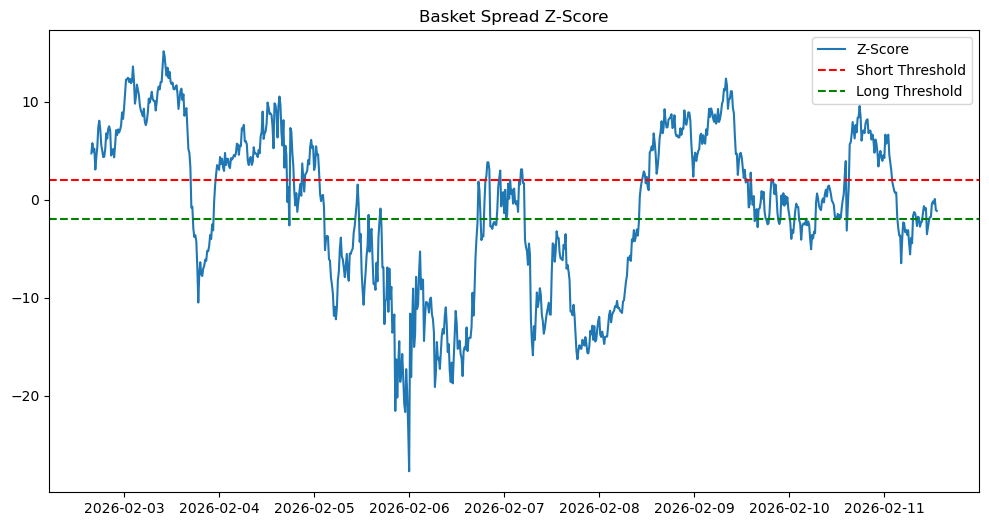

In [ ]:
# 1. Split Data
train_size = int(len(spread) * 0.7)
train_spread = spread.iloc[:train_size]
test_spread = spread.iloc[train_size:]

# 2. Fit OU Process on Train
ou_params = fit_ou_from_spread(train_spread)

if ou_params:
    print(f"Half-life: {ou_params['half_life']:.2f} periods")
    
    # 3. Calculate Z-Score on Test
    z_score = ou_zscore(test_spread, ou_params["mu"], ou_params["sigma"])
    
    # 4. Generate Signals
    signals = percentile_signals(z_score, lookback=90)
    
    # Plotting to visualize
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    plt.plot(z_score, label="Z-Score")
    plt.axhline(2.0, color="r", linestyle="--", label="Short Threshold")
    plt.axhline(-2.0, color="g", linestyle="--", label="Long Threshold")
    plt.legend()
    plt.title("Basket Spread Z-Score")
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_strategy_returns(prices_df, basket_weights, signals):
    """
    Calculates the PnL of the basket trading strategy.
    
    Parameters:
    - prices_df: DataFrame of Close prices (raw prices, not log)
    - basket_weights: Series of weights from LASSO
    - signals: Series of 1, -1, 0 signals
    """
    # 1. Calculate Log Returns for all coins
    # Log Returns = ln(P_t) - ln(P_{t-1})
    log_returns = np.log(prices_df).diff().dropna()
    
    # 2. Align Signals with Returns
    # We trade AT THE CLOSE of the signal candle, so we realize the return of the NEXT candle.
    # Therefore, we shift signals forward by 1.
    aligned_signals = signals.shift(1)
    aligned_signals = aligned_signals.reindex(log_returns.index).fillna(0)


    
    # 3. Calculate "Basket Return"
    # This is the weighted sum of returns of the coins in your basket
    # If Basket = {ETH: 0.5, SOL: 0.2}, Basket Return = 0.5*Ret_ETH + 0.2*Ret_SOL
    # Ensure we only use coins that are actually in the basket
    basket_cols = basket_weights.index
    basket_ret = (log_returns[basket_cols] * basket_weights).sum(axis=1)
    
    # 4. Calculate Strategy Return
    # Spread Return = BTC Return - Basket Return
    # Strategy Return = Signal * Spread Return
    # (If Signal=1, we want Spread to go UP. If Signal=-1, we want Spread to go DOWN)
    spread_ret = log_returns['BTC'] - basket_ret
    strategy_ret = aligned_signals * spread_ret
    
    # Optional: Deduct Transaction Costs (e.g., 0.1% per trade)
    # trades = aligned_signals.diff().abs()  # 1 if position changed
    # costs = trades * 0.001
    # strategy_ret = strategy_ret - costs
    
    return strategy_ret

# --- EXECUTION ---
# Ensure 'signals' and 'basket' are from your previous steps
strat_returns = calculate_strategy_returns(df_close_15m, basket_weights, signals)

# Calculate Cumulative Return (Equity Curve)
cumulative_ret = strat_returns.cumsum()

print("Total Return:", cumulative_ret.iloc[-1])

Total Return: 0.027577449418627612
